## Repeat : minibatch, epoch

### Settings

In [1]:
!pip install plotly_express

In [2]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D   
import matplotlib.ticker as mticker
from scipy.stats import reciprocal
%matplotlib inline

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score  # accuracy, coefficient of determination

import pandas as pd
import numpy as np
import random as rn

import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
rn.seed(42)
np.random.seed(42)   # np.random 모듈의 추출결과 고정하기 위해..

### Load data

In [4]:
df = pd.read_csv('./foreign_flyash.csv')
df = df.drop("ID", axis=1)
df

,Al2O3,CaO,Fe2O3,SiO2,MgO,Na2O+0.658K2O,aluminosilicate
0,29.5,1.1,4.6,53.8,0.7,1.85,61.08
1,20.7,10.2,7.1,51.4,3.0,1.26,63.30
2,17.8,10.6,7.6,55.3,2.3,1.02,59.11
3,22.8,11.9,3.8,51.6,2.0,0.73,57.07
4,21.6,13.6,4.3,42.9,2.5,8.36,61.59
...,...,...,...,...,...,...,...
86,26.0,2.4,8.6,53.2,1.6,2.28,68.45
87,17.9,27.3,8.4,28.5,3.8,0.86,36.98
88,25.9,2.3,8.8,48.2,1.5,2.21,53.62
89,33.4,2.4,6.4,50.8,0.8,0.86,56.67


In [5]:
features = np.array(df.columns)

In [6]:
df.iloc[:,6].describe()

count    91.000000
mean     54.183956
std      12.668110
min      13.600000
25%      46.615000
50%      56.670000
75%      62.450000
max      73.890000
Name: aluminosilicate, dtype: float64

### Deeply check data

#### 1. Stratified sampling

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103

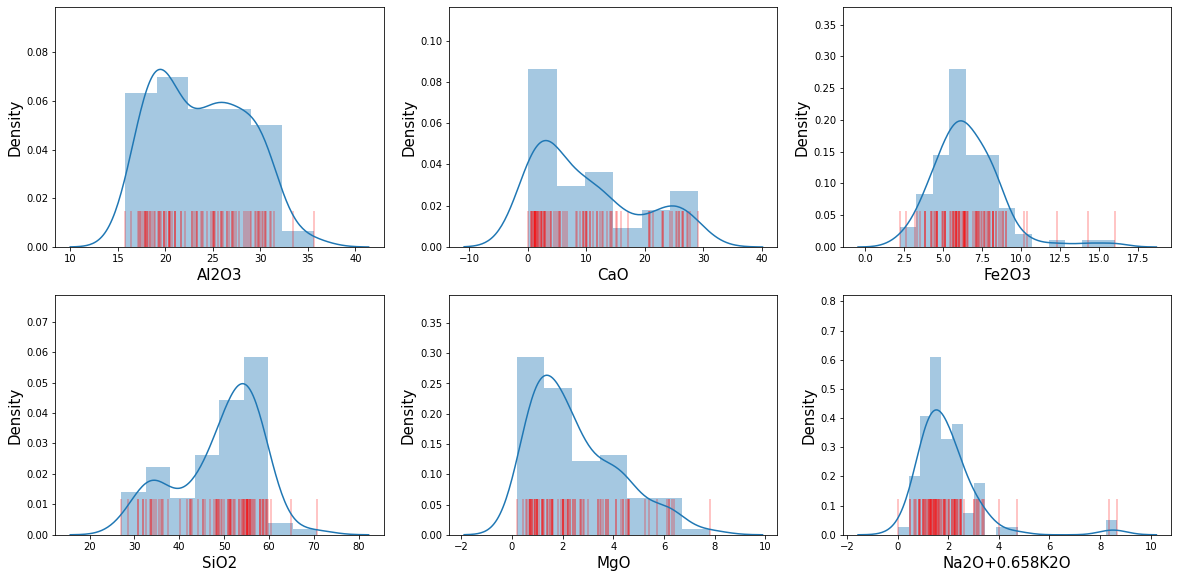

In [7]:
var=np.arange(1,len(df.columns))
var

figsize(20, 15)
for i in var:
    plt.subplot(3,3,i)
    p = sns.distplot(df.iloc[:,(i-1)], rug=True,
                     rug_kws = {'color':'r', 'alpha':0.3, 'linewidth':1.5, 'height':0.15})      # bins = n_samples, dist
    p.set_xlabel(features[i-1], fontsize=15)
    p.set_ylabel('Density', fontsize=15)

plt.savefig('./distrb_input_feature.png')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)


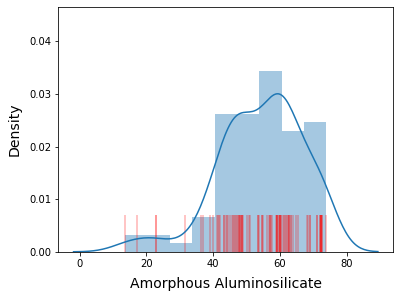

In [8]:
plt.subplots(figsize=(6,4.5))
p = sns.distplot(df.iloc[:,6], rug=True,
                  rug_kws = {'color':'r', 'alpha':0.3, 'linewidth':1.5, 'height':0.15})      # bins = n_samples, dist
p.set_xlabel('Amorphous Aluminosilicate', fontsize=14, labelpad=8)
p.set_ylabel('Density', fontsize=14, labelpad=8)

plt.savefig('./distrb_output_feature.png')

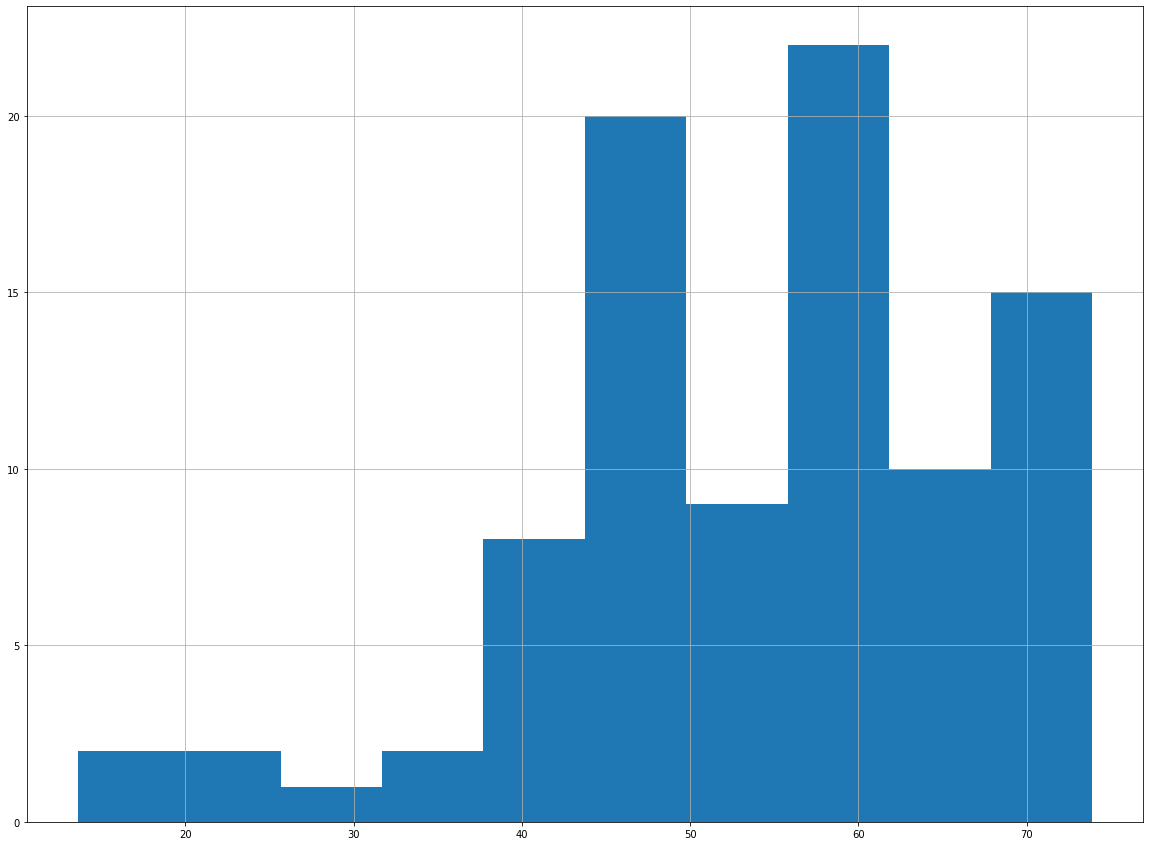

In [9]:
df['aluminosilicate'].hist()

1    19
2    18
3    18
4    18
5    18
Name: aluminosilicate_cat, dtype: int64


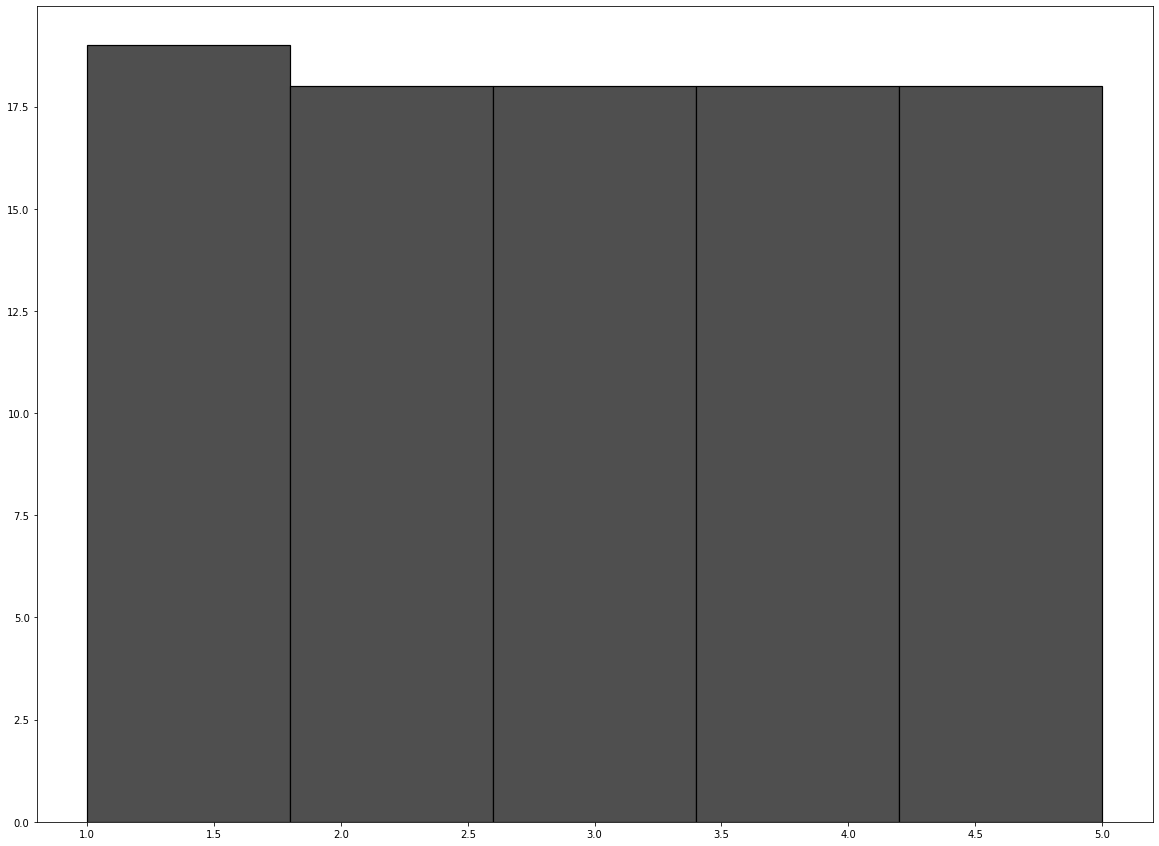

In [10]:
dist = [0.,
        df['aluminosilicate'].quantile(0.2),
        df['aluminosilicate'].quantile(0.4),
        df['aluminosilicate'].quantile(0.6),
        df['aluminosilicate'].quantile(0.8),
        np.inf]

df['aluminosilicate_cat'] = pd.cut(df['aluminosilicate'], 
                                     bins=dist, 
                                     labels=[1,2,3,4,5])
print(df['aluminosilicate_cat'].value_counts())
df['aluminosilicate_cat'].hist(color='#4F4F4F', grid=False, bins=5, edgecolor='black', linewidth=1.2)

In [11]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.145, random_state=42)

for train_idx, test_idx in split.split(df, df["aluminosilicate_cat"]):
    strat_train = df.loc[train_idx]
    strat_test = df.loc[test_idx]

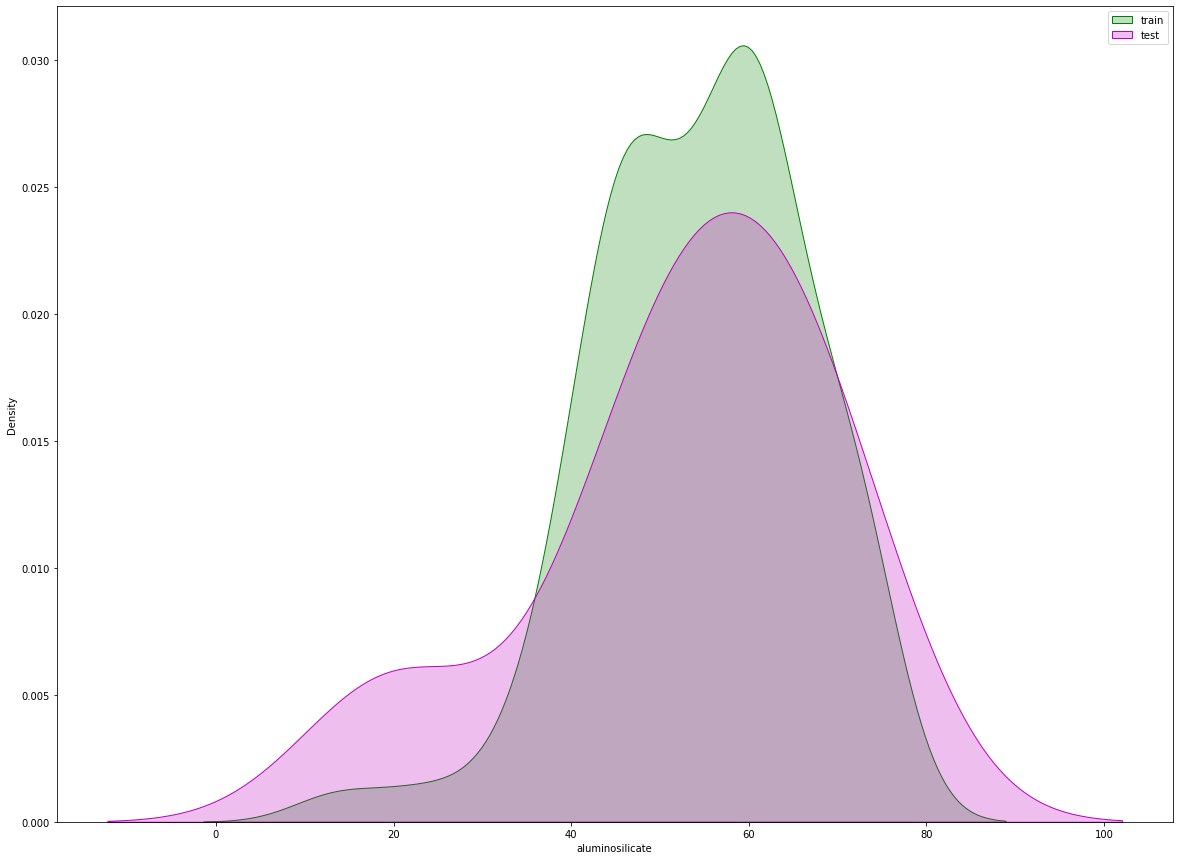

In [12]:
# Stratified Sampling
sns.kdeplot(strat_train['aluminosilicate'], color="g", fill=True, label="train")
# sns.kdeplot(df.loc[idx_val, col], color="c", fill=True, ax=ax, label="val.")
sns.kdeplot(strat_test['aluminosilicate'], color="m", fill=True,  label="test")
plt.legend()
# plt.show()

plt.savefig('./stratified_sampling.png')

In [13]:
df.shape[0]

91

In [14]:
strat_train.shape[0]

77

In [15]:
strat_test.shape[0]

14

Comparing to random sampling.

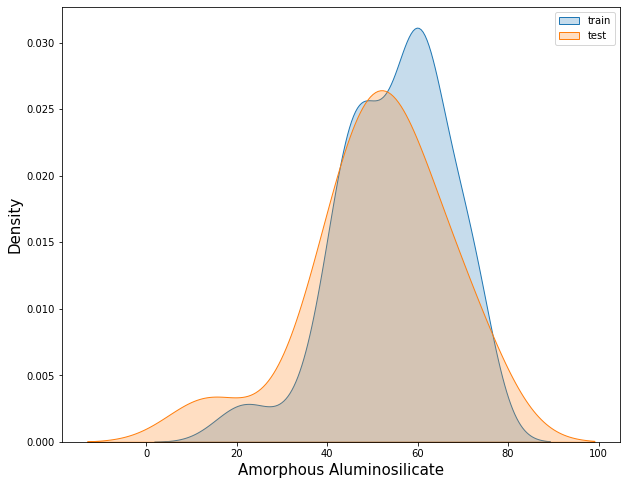

In [16]:
# (vs.) Ordinary Sampling
x_train, x_test, y_train, y_test = train_test_split(df, df['aluminosilicate'], 
                                                      test_size=0.145, shuffle=True, random_state=42) # stratify=target,
plt.figure(figsize=(10,8))
sns.kdeplot(y_train, fill=True, label="train")
sns.kdeplot(y_test, fill=True,  label="test")
plt.legend()

font = {'size' : 15}
plt.xlabel('Amorphous Aluminosilicate', fontdict=font)
plt.ylabel('Density', fontdict=font)
# plt.show()

plt.savefig('sampling.png')

In [17]:
def amorphous_cat_proportions(data):
    return data["aluminosilicate_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(df, test_size=0.145, random_state=42)  # 랜덤 샘플링

compare_props = pd.DataFrame({
    "Overall": amorphous_cat_proportions(df),
    "Stratified": amorphous_cat_proportions(strat_test),
    "Random": amorphous_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1,0.208791,0.214286,0.285714,36.842105,2.631579
2,0.197802,0.214286,0.214286,8.333333,8.333333
3,0.197802,0.142857,0.214286,8.333333,-27.777778
4,0.197802,0.214286,0.142857,-27.777778,8.333333
5,0.197802,0.214286,0.142857,-27.777778,8.333333


In [18]:
for set_ in (strat_train, strat_test):
    set_.drop("aluminosilicate_cat", axis=1, inplace=True)

In [19]:
# # Visualization data 

# df = strat_train.copy()  # 복사본

# import plotly_express as px

# px.scatter_ternary(df,
#                    a="SiO2", b="CaO", c="Al2O3",
#                    color="n_c",
#                    size_max=15,
#                    )

#### 3. Preparations

1) Separation of the label from the training set.

In [20]:
flyash = strat_train.iloc[:,0:6]
flyash_labels = strat_train.iloc[:,6]

2) Seperation of the label from the test set.

In [21]:
X_test = strat_test.iloc[:,0:6]
y_test = strat_test.iloc[:,6]

3) Feature Scailing (**Caution: Appling the fit method only to training set.)

In [22]:
flyash_labels = flyash_labels.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [23]:
scalerX = StandardScaler().fit(flyash)
scalery = StandardScaler().fit(flyash_labels)

flyash_scaled = scalerX.transform(flyash)
flyash_labels_scaled = scalery.transform(flyash_labels)

X_test_scaled = scalerX.transform(X_test)
y_test_scaled = scalery.transform(y_test)

In [24]:
# Save scaler
import joblib

joblib.dump(scalerX, "./scalerX.save") 
joblib.dump(scalery, "./scalery.save") 

# # And load...
# scaler = joblib.load(scaler_filename) 

['./scalery.save']


### Select model

In [25]:
mlp_model = MLPRegressor(solver='lbfgs',hidden_layer_sizes=(10,3), max_iter=500, alpha=0.1,    # 여기서, max_iter, alpha값은 무의미하다..
                         random_state=42, shuffle=False,
                         validation_fraction=0.18, activation="relu") # .fit(flyash_scaled, flyash_labels_scaled)

### Tune model

#### 1. Exploring hyperparameters, Cross-validation

Error : A column-vector y was passed

In [26]:
flyash_labels_scaled = np.ravel(flyash_labels_scaled)
flyash_scaled = pd.DataFrame(flyash_scaled, columns=['Al2O3', 'CaO', 'Fe2O3', 'SiO2', 'MgO', 'Na2O+0.658K2O'] )
flyash_labels_scaled = pd.Series(flyash_labels_scaled, name='aluminosilicate')

Mini-batch gradient descent

In [27]:
# Delete Warning Message
import logging
logging.disable(30)

In [28]:
import warnings
warnings.filterwarnings(action='ignore')

batch_size를 해서.. 모델 성능을 높이기 위해서 입맞에 맞는 데이터만 사용한 것이다.

##### 91개 데이터 중에서, (1)70개를 random으로 고르고 (2) GridSearchCV으로 train 데이터를 train-valid로 나눠서 max_iter, alpha의 best 파라미터를 찾는 것이다.

In [35]:
iters_num = 1000 # (Hyper-parameter)
train_size = flyash_scaled.shape[0]
batch_size = 65 # mini-batch size, 77개 중에서 65

param_grid = [
    # two-step
    {'max_iter': [50, 100, 200, 300, 500, 1000, 2000]},
    {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1,1, 10, 100]},
    ]

# 학습률 그래프 그리기 위한 변수 선언
train_r2_list = []
test_r2_list = []

# The number of repetitions per epoch
iter_per_epoch = round(train_size/batch_size)

np.random.seed(42)
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)

    flyash_batch = flyash_scaled.iloc[batch_mask,]
    flyash_labels_batch = flyash_labels_scaled.iloc[batch_mask,]

    grid_search = GridSearchCV(mlp_model, param_grid, cv=5,
                             scoring='neg_mean_squared_error',
                             return_train_score=True)
    grid_search.fit(flyash_batch, flyash_labels_batch)
    
    
    # Accuracy per epoch
    model = grid_search.best_estimator_
    train_predictions = model.predict(flyash_scaled)
    test_predictions = model.predict(X_test_scaled)

    r2_train = r2_score(flyash_labels_scaled, train_predictions)
    r2_test = r2_score(y_test_scaled, test_predictions)
    
    train_r2_list.append(r2_train)
    test_r2_list.append(r2_test)
    print(i,'번째 iterations, train acc, test acc :', str(r2_train),',',str(r2_test))

0 번째 iterations, train acc, test acc : 0.25524261720660324 , 0.5524815803710101
1 번째 iterations, train acc, test acc : 0.6075363511713234 , 0.7085137555488485
2 번째 iterations, train acc, test acc : 0.3952436712435282 , 0.06696663883930143
3 번째 iterations, train acc, test acc : 0.5854280443739431 , 0.6890053052786537
4 번째 iterations, train acc, test acc : 0.16087692758619065 , 0.021970450298277044
5 번째 iterations, train acc, test acc : 0.3159243826444188 , 0.5640848195798758
6 번째 iterations, train acc, test acc : 0.7086791547739004 , 0.6214098795425436
7 번째 iterations, train acc, test acc : -0.0643332713330973 , -0.004890929858050619
8 번째 iterations, train acc, test acc : 0.11368177240978872 , -0.13622062333051654
9 번째 iterations, train acc, test acc : 0.5497285653504691 , 0.6770228761872578
10 번째 iterations, train acc, test acc : 0.4411950531352541 , 0.3763829109881236
11 번째 iterations, train acc, test acc : 0.6952932669416583 , 0.44279354330213205
12 번째 iterations, train acc, test acc

##### 찾은 결과값을 반영해서 iter_nums 값 설정

In [30]:
iters_num = 622   # (621번째 출력에서 r2_score : 0.81, 0.77)
train_size = flyash_scaled.shape[0]
batch_size = 65 # mini-batch size

param_grid = [
    # two-step
    {'max_iter': [50, 100, 200, 300, 500, 1000, 2000]},
    {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1,1, 10, 100]},
    ]

# 학습률 그래프 그리기 위한 변수 선언
train_r2_list = []
test_r2_list = []

# The number of repetitions per epoch
iter_per_epoch = round(train_size/batch_size)

np.random.seed(42)
for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)   # 난수를 통해 batch data 샘플링

    flyash_batch = flyash_scaled.iloc[batch_mask,]
    flyash_labels_batch = flyash_labels_scaled.iloc[batch_mask,]

    grid_search = GridSearchCV(mlp_model, param_grid, cv=5,
                             scoring='neg_mean_squared_error',
                             return_train_score=True)
    grid_search.fit(flyash_batch, flyash_labels_batch)        # grid_search 는 batch data로만 진행
    
    
    # Accuracy per epoch... 전체 train과 test data에서 평가
      
    model = grid_search.best_estimator_
    train_predictions = model.predict(flyash_scaled)      
    test_predictions = model.predict(X_test_scaled)

    r2_train = r2_score(flyash_labels_scaled, train_predictions)
    r2_test = r2_score(y_test_scaled, test_predictions)
    
    train_r2_list.append(r2_train)
    test_r2_list.append(r2_test)
    print(i,'번째 iterations, train acc, test acc |', str(r2_train),',',str(r2_test))

0 번째 iterations, train acc, test acc | 0.25524261720660324 , 0.5524815803710101
1 번째 iterations, train acc, test acc | 0.6075363511713234 , 0.7085137555488485
2 번째 iterations, train acc, test acc | 0.3952436712435282 , 0.06696663883930143
3 번째 iterations, train acc, test acc | 0.5854280443739431 , 0.6890053052786537
4 번째 iterations, train acc, test acc | 0.16087692758619065 , 0.021970450298277044
5 번째 iterations, train acc, test acc | 0.3159243826444188 , 0.5640848195798758
6 번째 iterations, train acc, test acc | 0.7086791547739004 , 0.6214098795425436
7 번째 iterations, train acc, test acc | -0.0643332713330973 , -0.004890929858050619
8 번째 iterations, train acc, test acc | 0.11368177240978872 , -0.13622062333051654
9 번째 iterations, train acc, test acc | 0.5497285653504691 , 0.6770228761872578
10 번째 iterations, train acc, test acc | 0.4411950531352541 , 0.3763829109881236
11 번째 iterations, train acc, test acc | 0.6952932669416583 , 0.44279354330213205
12 번째 iterations, train acc, test acc

Draw graph

In [51]:
df

,Al2O3,CaO,Fe2O3,SiO2,MgO,Na2O+0.658K2O,Amorphous_content
0,20.9,2.7,5.2,64.8,1.4,1.7,72.0
1,20.8,2.7,5.0,65.0,1.4,1.8,70.0
2,20.9,5.7,8.2,55.9,2.0,2.4,80.0
3,21.3,4.0,6.4,59.5,1.5,1.2,59.0
4,20.1,4.1,8.7,58.8,2.0,1.8,70.0
...,...,...,...,...,...,...,...
57,22.9,5.5,7.7,55.9,1.8,2.2,74.0
58,21.2,3.9,6.3,62.7,1.5,0.8,80.7
59,22.9,6.4,9.0,52.0,1.8,2.9,77.0
60,20.1,3.4,5.6,53.7,0.9,1.9,74.4


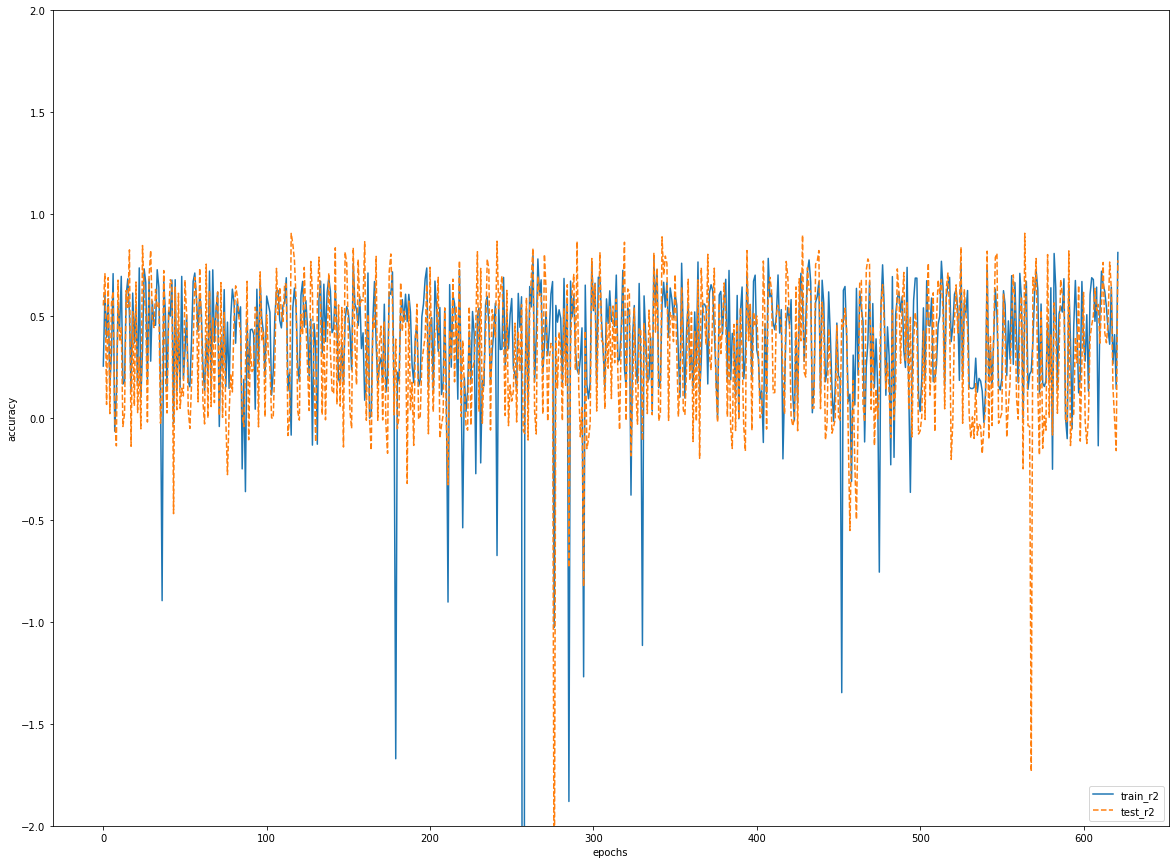

In [52]:
markers = {'train':'o', 'test':'s'}
x = np.arange(len(train_r2_list))
plt.plot(x,train_r2_list, label='train_r2')
plt.plot(x, test_r2_list, label='test_r2', linestyle='--')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(-2,2)
plt.legend(loc='lower right')
plt.show()

### Evaluation of System, Test set

Error : A column-vector y was passed

In [53]:
# ValueError: Expected 2D array, got 1D array instead:

flyash_labels = flyash_labels.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [54]:
y_test_scaled = np.ravel(y_test_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=['Al2O3', 'CaO', 'Fe2O3', 'SiO2', 'MgO', 'Na2O+0.658K2O'])

y_test_scaled = pd.DataFrame(y_test_scaled)
flyash_labels_scaled = pd.DataFrame(flyash_labels_scaled)
train_predictions = pd.DataFrame(train_predictions)
test_predictions = pd.DataFrame(test_predictions)

In [55]:
def mape(y_pred, y):
    return np.mean(np.abs((y_pred - y) / y)) * 100

final_model = grid_search.best_estimator_
train_predictions = final_model.predict(flyash_scaled)
test_predictions = final_model.predict(X_test_scaled)

r2_train = r2_score(flyash_labels_scaled, train_predictions)
r2_test = r2_score(y_test_scaled, test_predictions)

In [56]:
print("Train set(85%)")
print("R^2", (r2_train))
# print("MAPE", mape(train_predictions, flyash_labels_scaled))
print("========================")
print("Test set(15%)")
print("R^2", (r2_test))
# print("MAPE", mape(test_predictions, y_test_scaled))

Train set(85%)
R^2 0.8122369696008486
Test set(15%)
R^2 0.7739679989077288


### 모델 해석성

#### 1) ELI5

In [57]:
pip install eli5

In [58]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(final_model, random_state=42).fit(X_test_scaled, y_test_scaled)   # scoring 파라미터, mlpregressor_gridsearch에서 scoring= 'neg_mean_squared_error' 사용하였기 때문에
explanation = eli5.formatters.as_dataframe.explain_weights_df(perm,feature_names = df.columns[:-2].tolist())
# explanation_pred = eli5.explain_prediction_df(estimator=final_model, doc=X_test_scaled.iloc[0])

ValueError: ignored

In [ ]:
explanation

In [39]:
eli5.show_weights(perm, feature_names = df.columns[:-2].tolist(),
                  show = ['feature_importances', 'method', 'description'])   # +- std*2

Weight,Feature
7.0316 ± 1.1626,CaO
1.2024 ± 0.7021,MgO
0.5950 ± 0.0631,Al2O3
0.5685 ± 0.3162,SiO2
0.3028 ± 0.2243,Fe2O3
0.0136 ± 0.0813,Na2O+0.658K2O


shuffle 후 모델의 성능 변화를 나타낸다. 

weight가 음수값인 변수들은, shuffle된 데이터가 실제 데이터보다 더 정확한 경우이다. (즉 해당 feature을 제외하니까 모델 성능이 더 좋아진 경우)

#### 2) SHAP

In [40]:
pip install shap

     |████████████████████████████████| 564 kB 4.3 MB/s 


  0%|          | 0/14 [00:00<?, ?it/s]

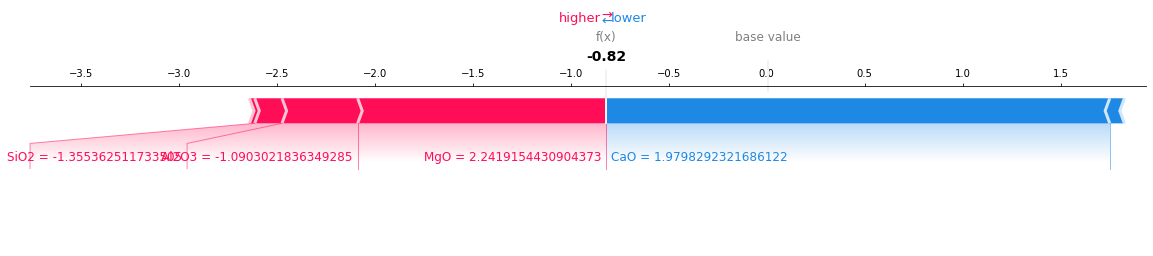

In [41]:
# shap value 
import shap
import skimage

explainer = shap.KernelExplainer(final_model.predict, flyash_scaled)
shap_values = explainer.shap_values(X_test_scaled)

shap.initjs()
# test set 하나에 대해서 적용
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test_scaled.iloc[1,:],
                      show=False, matplotlib=True).savefig('influence_one_of_test.png')

Remember that shap values are calculated for each feature and for each record.

In [42]:
# test set 전체에 대해서 적용
shap.initjs()
fig = shap.force_plot(explainer.expected_value, shap_values, X_test_scaled, show=False)
shap.save_html("influence_test_test.html",fig)

### Analysis

Back to before scaling

In [59]:
flyash_labels_inverse = scalery.inverse_transform(flyash_labels_scaled)
y_test_inverse = scalery.inverse_transform(y_test_scaled)

In [60]:
train_predictions = train_predictions.reshape(-1,1)
test_predictions = test_predictions.reshape(-1,1)

In [45]:
train_predictions_inverse = scalery.inverse_transform(train_predictions)
test_predictions_inverse = scalery.inverse_transform(test_predictions)

Graph

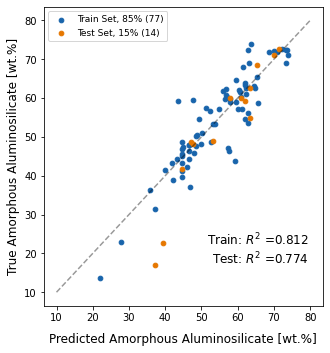

In [71]:
fig, ax = plt.subplots(figsize=(5,5.5))
ax.scatter(train_predictions_inverse, flyash_labels_inverse, color='#1864AB', label='Train Set, 85% (77)', s=22)
ax.scatter(test_predictions_inverse, y_test_inverse, color='#E67700', label='Test Set, 15% (14)', s=22)

# y=x dashed line
ax.plot([10,80], [10,80], c="k", linestyle='--',alpha=0.4)

font = {'size':12}
ax.set_xlabel("Predicted Amorphous Aluminosilicate [wt.%]", labelpad=10, fontdict=font)
ax.set_ylabel("True Amorphous Aluminosilicate [wt.%]", labelpad=4, fontdict=font)
ax.legend(fontsize=9, loc="upper left")


ax.text(0.95, 0.14, f"Train: $R^2$ ={r2_train:0.3f}\nTest: $R^2$ ={r2_test:0.3f}",
        transform=ax.transAxes, fontsize=12, ha="right")

    
fig.savefig(f"./performence_foreign model.png")

Save Trained Model

In [61]:
# save
joblib.dump(final_model,"./Foreign_Model.pkl")

['./Foreign_Model.pkl']

## Apply New data (Our Lab's flyashes)

Bring in a Learning Model

### Apply Korean Data

In [78]:
df = pd.read_csv('./flyash.csv')
df.drop('ID', axis=1, inplace=True)
df.drop('LOI', axis=1, inplace=True)
df.drop('Amorphous Alumina', axis=1, inplace=True)
df.drop('Amorphous Silica', axis=1, inplace=True)
df

,Al2O3,CaO,Fe2O3,SiO2,MgO,Na2O+0.658K2O,Sum of amorphous aluminosilicates
0,20.9,2.7,5.2,64.8,1.4,1.7,60.00
1,20.8,2.7,5.0,65.0,1.4,1.8,58.00
2,20.9,5.7,8.2,55.9,2.0,2.4,60.00
3,21.3,4.0,6.4,59.5,1.5,1.2,44.00
4,20.1,4.1,8.7,58.8,2.0,1.8,52.00
...,...,...,...,...,...,...,...
57,22.9,5.5,7.7,55.9,1.8,2.2,55.20
58,21.2,3.9,6.3,62.7,1.5,0.8,66.70
59,22.9,6.4,9.0,52.0,1.8,2.9,53.92
60,20.1,3.4,5.6,53.7,0.9,1.9,48.58


In [79]:
X_korean = df.iloc[:,0:6]
y_korean = df.iloc[:,6]

## Scailing data
y_korean = y_korean.values.reshape(-1,1)

X_korean_scaled = scalerX.transform(X_korean)
y_korean_scaled = scalery.transform(y_korean)

## Predict data
korean_predictions = final_model.predict(X_korean_scaled)
r2_value = r2_score(y_korean_scaled,korean_predictions)
r2_value

-2.1654886877422133

### Combine graphs

In [80]:
# ValueError: Expected 2D array, got 1D array instead:

korean_predictions = pd.DataFrame(korean_predictions)

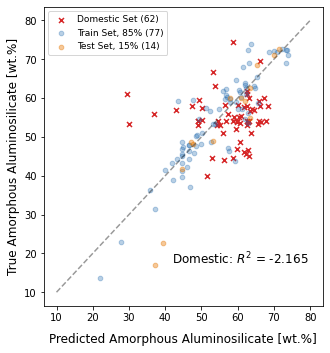

In [81]:
## Return before scailing
y_korean_inverse = scalery.inverse_transform(y_korean_scaled)
korean_predictions_inverse = scalery.inverse_transform(korean_predictions)

## Figure
fig, ax = plt.subplots(figsize=(5, 5.5))
ax.scatter(korean_predictions_inverse, y_korean_inverse, color='C3', label='Domestic Set (62)', s = 25, marker = 'x')  # koeran flyash
ax.scatter(train_predictions_inverse, flyash_labels_inverse, color='#1864AB', label='Train Set, 85% (77)', s=22, alpha=0.3)     # train data
ax.scatter(test_predictions_inverse, y_test_inverse, color='#E67700', label='Test Set, 15% (14)', s=22, alpha=0.4)              # test data

ax.plot([10,80], [10,80], c="k", linestyle='--',alpha=0.4) # y=x dashed line

font = { 'size' : 12}
ax.set_xlabel("Predicted Amorphous Aluminosilicate [wt.%]", labelpad=10, fontdict=font)
ax.set_ylabel("True Amorphous Aluminosilicate [wt.%]", labelpad=4, fontdict=font)
ax.legend(fontsize=9,loc="upper left")

# $Test: R^2 ={r2_test:0.3f}$
ax.text(0.95, 0.14, f"\nDomestic: $R^2$ = {r2_value:0.3f}", 
        transform=ax.transAxes, fontsize=12, ha="right")

fig.savefig(f"./performance_plus domestic.png")